연비예측 모델 만들기 <hr>
- 데이터 : auto.csv
- 피  처 : 
- 타  겟 : 연비 (mpg)

In [2]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

- from sklearn.model_selection import train_test_split : 훈련용 데이터 및 테스트 데이터 split 하기

- StandardScaler : 표준화 스케일러

- MinMaxScaler: 데이터를 최소-최댓값 사이 범위로 스케일링하는 스케일러. (보통 0, 1 사이)   

- RobustScaler : 데이터의 중앙값(median)과 사분위수 범위(interquartile range, IQR)를 사용하여 이상치의 영향을 줄이고 스케일을 조정
    + 데이터에 이상치가 있는 경우나 데이터의 분포가 비대칭인 경우에 유용하게 사용

In [3]:
# 데이터 불러오기
data = '../data/auto-mpg.csv'

pd.read_csv(data).columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')

- 1) mpg: 연비

- 2) cylinders: 실린더 개수

- 3) displacement: 배기량

- 4) horsepower: 마력

- 5) weight: 무게

- 6) acceleration: 엔진이 초당 얻을 수 있는 가속력

- 7) model year: 출시 년도

- 8) origin: 제조 장소(1: 미국 USA, 2: 유럽 EU, 3: 일본 JPN)

- 9) car name: 자동차 이름

In [4]:
autoDF = pd.read_csv(data)

In [5]:
# 데이터 확인
autoDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
# 결측치 확인 => 결측값 없음
autoDF.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [7]:
# 이상치 확인 => 마력 컬럼에서 ? 발견.

for col in autoDF.columns :
    print(f'{col} :', autoDF[col].sort_values(ascending=False))
    print()

mpg : 322    46.6
329    44.6
325    44.3
394    44.0
326    43.4
       ... 
103    11.0
67     11.0
25     10.0
26     10.0
28      9.0
Name: mpg, Length: 398, dtype: float64

cylinders : 0      8
86     8
230    8
231    8
232    8
      ..
81     4
243    3
334    3
71     3
111    3
Name: cylinders, Length: 398, dtype: int64

displacement : 8      455.0
95     455.0
13     455.0
6      454.0
7      440.0
       ...  
131     71.0
111     70.0
71      70.0
334     70.0
117     68.0
Name: displacement, Length: 398, dtype: float64

horsepower : 354      ?
374      ?
126      ?
330      ?
32       ?
      ... 
98     100
99     100
107    100
127    100
199    100
Name: horsepower, Length: 398, dtype: object

weight : 44     5140
103    4997
42     4955
90     4952
95     4951
       ... 
53     1773
345    1760
343    1755
144    1649
54     1613
Name: weight, Length: 398, dtype: int64

acceleration : 299    24.8
394    24.6
326    23.7
59     23.5
300    22.2
       ... 
116     9.5

In [8]:
# 이상치 '?'를 replace한 다음 int로 형 변환.
# autoDF['horsepower'] = autoDF['horsepower'].replace({'?':0}).copy()
# autoDF['horsepower'] = autoDF['horsepower'].astype(int)
# autoDF['horsepower']

- pd.to_numeric(시리즈, error = 'coerce')
    * str인 숫자 데이터를 수치형 데이터로 형변환. 
    * errors = 'coerce' : error를 결측치로 변환해줌.
    * errors = 'raise' : error를 일으킴
    * errors = 'ignore' : 2.2부터 빠질 예정. error를 무시함.

- pipeline(https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline)
* verbosebool, default=False : <If True, the time elapsed while fitting each step will be printed as it is completed.>

In [9]:
autoDF['horsepower'] = pd.to_numeric(autoDF['horsepower'], errors= 'coerce')
  

# NaN으로 바뀐 것을 알 수 있댜.
autoDF['horsepower'].sort_values()

# horsepower의 NaN이 drop 되었다.
autoDF = autoDF.dropna()


In [10]:
autoDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [11]:
# 상관계수 확인. 숫자만 비교.
autoDF_corr = autoDF.corr(numeric_only=True)
# 절댓값으로 변환하고 내림차순으로 정렬하여 연비와 상관계수가 높은 컬럼 확인.
abs(autoDF_corr['mpg']).sort_values(ascending=False)

mpg             1.000000
weight          0.832244
displacement    0.805127
horsepower      0.778427
cylinders       0.777618
model year      0.580541
origin          0.565209
acceleration    0.423329
Name: mpg, dtype: float64

In [12]:
corrList = autoDF_corr['mpg'].to_list()

In [13]:
# 타겟과 피처 결정.
# 필요한 컬럼만 저장.
autoDF = autoDF[['mpg','weight', 'displacement', 'cylinders', 'horsepower']]
targetSR = autoDF['mpg']
featureDF = autoDF[['weight', 'displacement', 'cylinders', 'horsepower']]

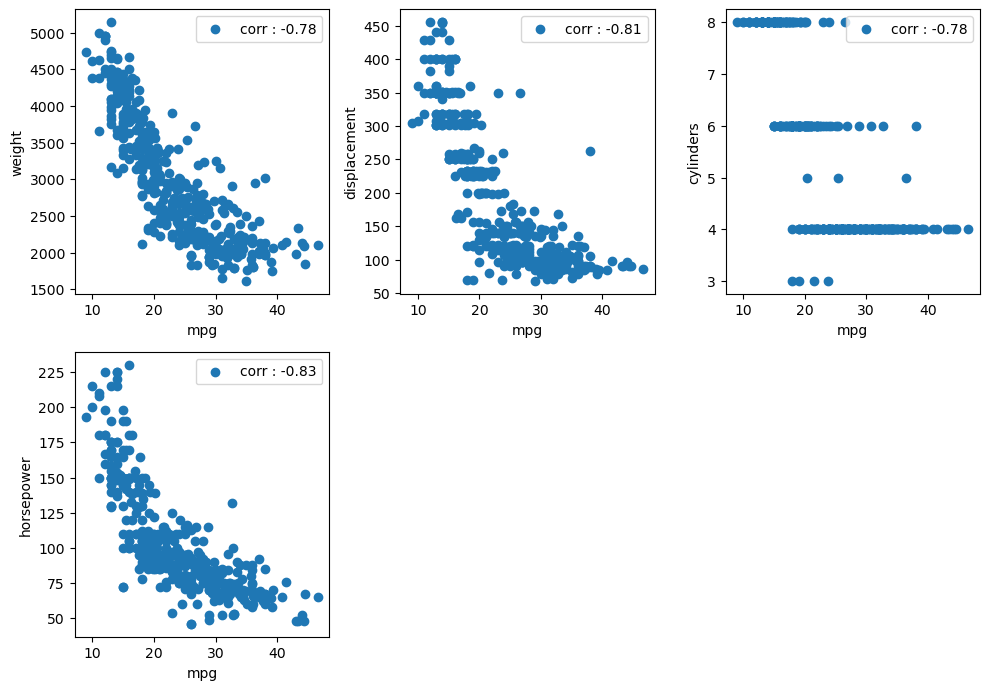

In [14]:
def print_feature(nrows, ncols, df, target, features, corrs) : 
    plt.figure(figsize=(10,10))
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx+1)
        plt.scatter(df[target], df[features[idx]], label =f'corr : {corrs[idx]:.2}')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout() # 간격 안 맞는 거 맞춰주는 건가..?
    plt.show()

print_feature(3, 3, autoDF, 'mpg', autoDF.columns[1:], corrList[1:])

- scale 차이가 크기 때문에 스케일링 진행 필요.
- cylinders는 연속적인 데이터가 아니기 때문에 제외.

In [15]:
autoDF = autoDF[['mpg','weight', 'displacement', 'horsepower']]
featureDF = autoDF[['weight', 'displacement', 'horsepower']]

In [16]:
# poly를 해보자!
# 모듈 로딩
from sklearn.preprocessing import PolynomialFeatures

# 인스턴스 생성
poly = PolynomialFeatures(include_bias=False)

auto_poly = pd.DataFrame(poly.fit_transform(featureDF), columns = poly.get_feature_names_out()) # degree 기본값 = 2
#auto_poly_without_target

In [17]:
# 훈련용 데이터와 테스트용 데이터로 분리
# train:test = 8:2

#X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.2, random_state=31)
X_train, X_test, y_train, y_test = train_test_split(auto_poly, targetSR, test_size=0.2, random_state=20)

In [18]:
# 훈련용 데이터 및 테스트용 데이터 확인
def print_train_test_data(X_train, X_test, y_train, y_test) :
    print(f'[훈련용] X_train : {X_train.shape}')
    print(X_train.head(2))
    print(f'\n[테스트용] X_test : {X_test.shape}')
    print(X_test.head(2))
    print(f'\n[훈련용] y_train : {y_train.shape}')
    print(y_train.head(2))
    print(f'\n[테스트용] y_test : {y_test.shape}')
    print(y_test.head(2))

print_train_test_data(X_train, X_test, y_train, y_test)

[훈련용] X_train : (313, 9)
     weight  displacement  horsepower    weight^2  weight displacement  \
269  2745.0         156.0       105.0   7535025.0             428220.0   
256  3380.0         231.0       105.0  11424400.0             780780.0   

     weight horsepower  displacement^2  displacement horsepower  horsepower^2  
269           288225.0         24336.0                  16380.0       11025.0  
256           354900.0         53361.0                  24255.0       11025.0  

[테스트용] X_test : (79, 9)
     weight  displacement  horsepower    weight^2  weight displacement  \
10   3563.0         383.0       170.0  12694969.0            1364629.0   
291  1925.0          89.0        71.0   3705625.0             171325.0   

     weight horsepower  displacement^2  displacement horsepower  horsepower^2  
10            605710.0        146689.0                  65110.0       28900.0  
291           136675.0          7921.0                   6319.0        5041.0  

[훈련용] y_train : (313,)


In [19]:
# 스케일링 
std_scaler = StandardScaler()
std_scaler.fit(X_train)

StandardScaler()

In [20]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)

MinMaxScaler()

In [21]:
rb_scaler = RobustScaler()
rb_scaler.fit(X_train)

RobustScaler()

In [22]:
# 3가지 버전의 스케일된 데이터셋 준비
std_X_train = std_scaler.transform(X_train)
std_X_test = std_scaler.transform(X_test)

minmax_X_train = minmax_scaler.transform(X_train)
minmax_X_test = minmax_scaler.transform(X_test)

rb_X_train = rb_scaler.transform(X_train)
rb_X_test = rb_scaler.transform(X_test)

In [23]:
# 학습 진행 
def print_score(n, modelname, scaled_x_train, scaled_x_test, name) :
    train_scoreList =[]
    test_scoreList =[]
    for i in range(n) :
        model = modelname()
        model.fit(scaled_x_train, y_train)
        train_score = model.score(scaled_x_train, y_train)
        test_score = model.score(scaled_x_test, y_test)
        train_scoreList.append(train_score)
        test_scoreList.append(test_score)

    print(f'[{name} 모델파라미터] ====>\ncoef_: {model.coef_}\nintercept_ : {model.intercept_}')
    print(f'Train Score{i+1} : {train_score} --- Test Score{i+1} : {test_score}\n')
    print(f'max train score : {max(train_scoreList)} --- max test Score : {max(test_scoreList)}')
    print(f'min train score : {min(train_scoreList)} --- min test Score : {min(test_scoreList)}\n')

In [24]:
from sklearn.linear_model import LinearRegression
print_score(100, LinearRegression, std_X_train, std_X_test, 'std')
print()
print_score(100, LinearRegression, minmax_X_train, minmax_X_test, 'minmax')
print()
print_score(100, LinearRegression, rb_X_train, rb_X_test, 'robust')

[std 모델파라미터] ====>
coef_: [ -2.60724061 -10.38582472  -4.21190932  -2.31236466   8.12196062
  -1.54326266  -4.93465566  15.48883907  -4.56266276]
intercept_ : 23.597124600638978
Train Score100 : 0.7456419163882984 --- Test Score100 : 0.8033907017220819

max train score : 0.7456419163882984 --- max test Score : 0.8033907017220819
min train score : 0.7456419163882984 --- min test Score : 0.8033907017220819


[minmax 모델파라미터] ====>
coef_: [-11.01171109 -39.70704685 -20.79482985 -10.26856075  31.49081429
  -6.8596727  -21.3527505   75.79843756 -24.60416927]
intercept_ : 37.65300859180076
Train Score100 : 0.7456419163882984 --- Test Score100 : 0.8033907017220818

max train score : 0.7456419163882984 --- max test Score : 0.8033907017220818
min train score : 0.7456419163882984 --- min test Score : 0.8033907017220818


[robust 모델파라미터] ====>
coef_: [ -4.08997491 -16.41635012  -5.22775052  -3.24183238  10.90831803
  -1.73822607  -6.00912381  15.71943406  -4.45075317]
intercept_ : 24.7238380654971

In [25]:
from sklearn.neighbors import KNeighborsRegressor
def print_score_k(n, modelname, scaled_x_train, scaled_x_test, name) :
    train_scoreList =[]
    test_scoreList =[]
    for k in range(1, n) :
        model = modelname(n_neighbors=k)
        model.fit(scaled_x_train, y_train)
        train_score = model.score(scaled_x_train, y_train)
        test_score = model.score(scaled_x_test, y_test)
        train_scoreList.append(train_score)
        test_scoreList.append(test_score)
    max_k=test_scoreList.index(max(test_scoreList))
    print(f'{name} model')
    print(f'Train Score{k} : {train_score} --- Test Score{k} : {test_score}\n')
    print(f'max train score : {max(train_scoreList)} --- max test Score : {max(test_scoreList)}')
    print(f'min train score : {min(train_scoreList)} --- min test Score : {min(test_scoreList)}\n')
    print('max_k :', max_k)

In [26]:
print_score_k(100, KNeighborsRegressor, std_X_train, std_X_test, 'std')
print()
print_score_k(100, KNeighborsRegressor, minmax_X_train, minmax_X_test, 'minmax')
print()
print_score_k(100, KNeighborsRegressor, rb_X_train, rb_X_test, 'robust')

std model
Train Score99 : 0.7043843163503289 --- Test Score99 : 0.7642633471849267

max train score : 0.9975877298964055 --- max test Score : 0.8576482749579151
min train score : 0.7043843163503289 --- min test Score : 0.7437323609120773

max_k : 4

minmax model
Train Score99 : 0.7033387212936946 --- Test Score99 : 0.7634574800177522

max train score : 0.9975877298964055 --- max test Score : 0.8565134045900328
min train score : 0.7033387212936946 --- min test Score : 0.7531399156048497

max_k : 7

robust model
Train Score99 : 0.7062049270904165 --- Test Score99 : 0.7668207113692229

max train score : 0.9975877298964055 --- max test Score : 0.8589814863124429
min train score : 0.7062049270904165 --- min test Score : 0.7103409035714723

max_k : 3


In [27]:
std_k = 5
model2 = KNeighborsRegressor(n_neighbors=std_k)
model2.fit(std_X_train, y_train) 

minmax_k = 7
model2 = KNeighborsRegressor(n_neighbors=minmax_k)
model2.fit(minmax_X_train, y_train) 

rb_k = 3
model2 = KNeighborsRegressor(n_neighbors=minmax_k)
model2.fit(rb_X_train, y_train) 

KNeighborsRegressor(n_neighbors=7)

In [28]:
print('std_train : ', model2.score(std_X_train, y_train))
print('std_test : ', model2.score(std_X_test, y_test))
print('minmax_test : ', model2.score(minmax_X_train, y_train))
print('minmax_test : ', model2.score(minmax_X_test, y_test))
print('robust_train : ', model2.score(rb_X_train, y_train))
print('robust_test : ', model2.score(rb_X_test, y_test)) # 31 -> 82%

std_train :  0.5710324948980795
std_test :  0.6406092870164846
minmax_test :  0.4179909466457421
minmax_test :  0.48849793136270836
robust_train :  0.778807850100949
robust_test :  0.8530433118522849


In [29]:
# 성능 평가

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 모델의 성능을 평가할 떄 사용함

def evolution(scaled_X_test):

    y_pre = model2.predict(scaled_X_test) # 예측값 계산

    y_pre = np.round(y_pre, 1)

    print('[성능평가]')


    # 1) MSE
    print('1) 평균제곱오차:', mean_squared_error(y_test, y_pre))

    # 2) MAE
    print('2) 평균절대오차:', mean_absolute_error(y_test, y_pre))

    # 3) R2
    r2_scores = r2_score(y_test, y_pre)
    print('3) 루트제곱오차:', r2_scores)

    # 4) RMSE
    rmse = mean_squared_error(y_test, y_pre, squared=False)
    print('4) 평균제곱근오차:', rmse)

print('[std]')
evolution(std_X_test)
print()
print('[minmax]')
evolution(minmax_X_test)
print()
print('[robust]')
evolution(rb_X_test)

[std]
[성능평가]
1) 평균제곱오차: 23.322025316455694
2) 평균절대오차: 3.5569620253164542
3) 루트제곱오차: 0.6407698431471194
4) 평균제곱근오차: 4.829288282599797

[minmax]
[성능평가]
1) 평균제곱오차: 33.210632911392395
2) 평균절대오차: 4.430379746835443
3) 루트제곱오차: 0.4884551959762643
4) 평균제곱근오차: 5.762866726846318

[robust]
[성능평가]
1) 평균제곱오차: 9.55367088607595
2) 평균절대오차: 2.212658227848101
3) 루트제곱오차: 0.8528443973300931
4) 평균제곱근오차: 3.090901306427617
